In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# from tensorflow import keras
# from tensorflow.keras import layers

In [2]:
df = pd.read_csv("train.csv")
ntrain = df.shape[0]
test = pd.read_csv("test.csv")
ntest = df.shape[0]

In [3]:
all_data = pd.concat((df, test)).reset_index(drop=True)
all_data.drop(["SalePrice"], axis=1,inplace=True)
all_data.drop(["Id"], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


In [4]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
MasVnrType,60.500171
FireplaceQu,48.646797
LotFrontage,16.649538
GarageFinish,5.447071
GarageQual,5.447071
GarageCond,5.447071


In [5]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [6]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2919, 288)


In [7]:
train = all_data[:ntrain]
train =pd.concat((train, df["SalePrice"]), axis=1).reset_index(drop=True)
train =pd.concat((train, df["Id"]), axis=1).reset_index(drop=True)

test1 = all_data[ntrain:]
test1 = test1.reset_index()
test1 = test1.rename(columns={"index":"Id"})


In [8]:

correlation_matrix = train.corr()["SalePrice"]
high_corr_column = correlation_matrix[abs(correlation_matrix) > 0.6]
extracted_df = train[high_corr_column.index]
print(extracted_df.head())

   OverallQual  TotalBsmtSF  1stFlrSF  GrLivArea  GarageCars  GarageArea  \
0            7        856.0       856       1710         2.0       548.0   
1            6       1262.0      1262       1262         2.0       460.0   
2            7        920.0       920       1786         2.0       608.0   
3            7        756.0       961       1717         3.0       642.0   
4            8       1145.0      1145       2198         3.0       836.0   

   TotalSF  SalePrice  
0   2566.0     208500  
1   2524.0     181500  
2   2706.0     223500  
3   2473.0     140000  
4   3343.0     250000  


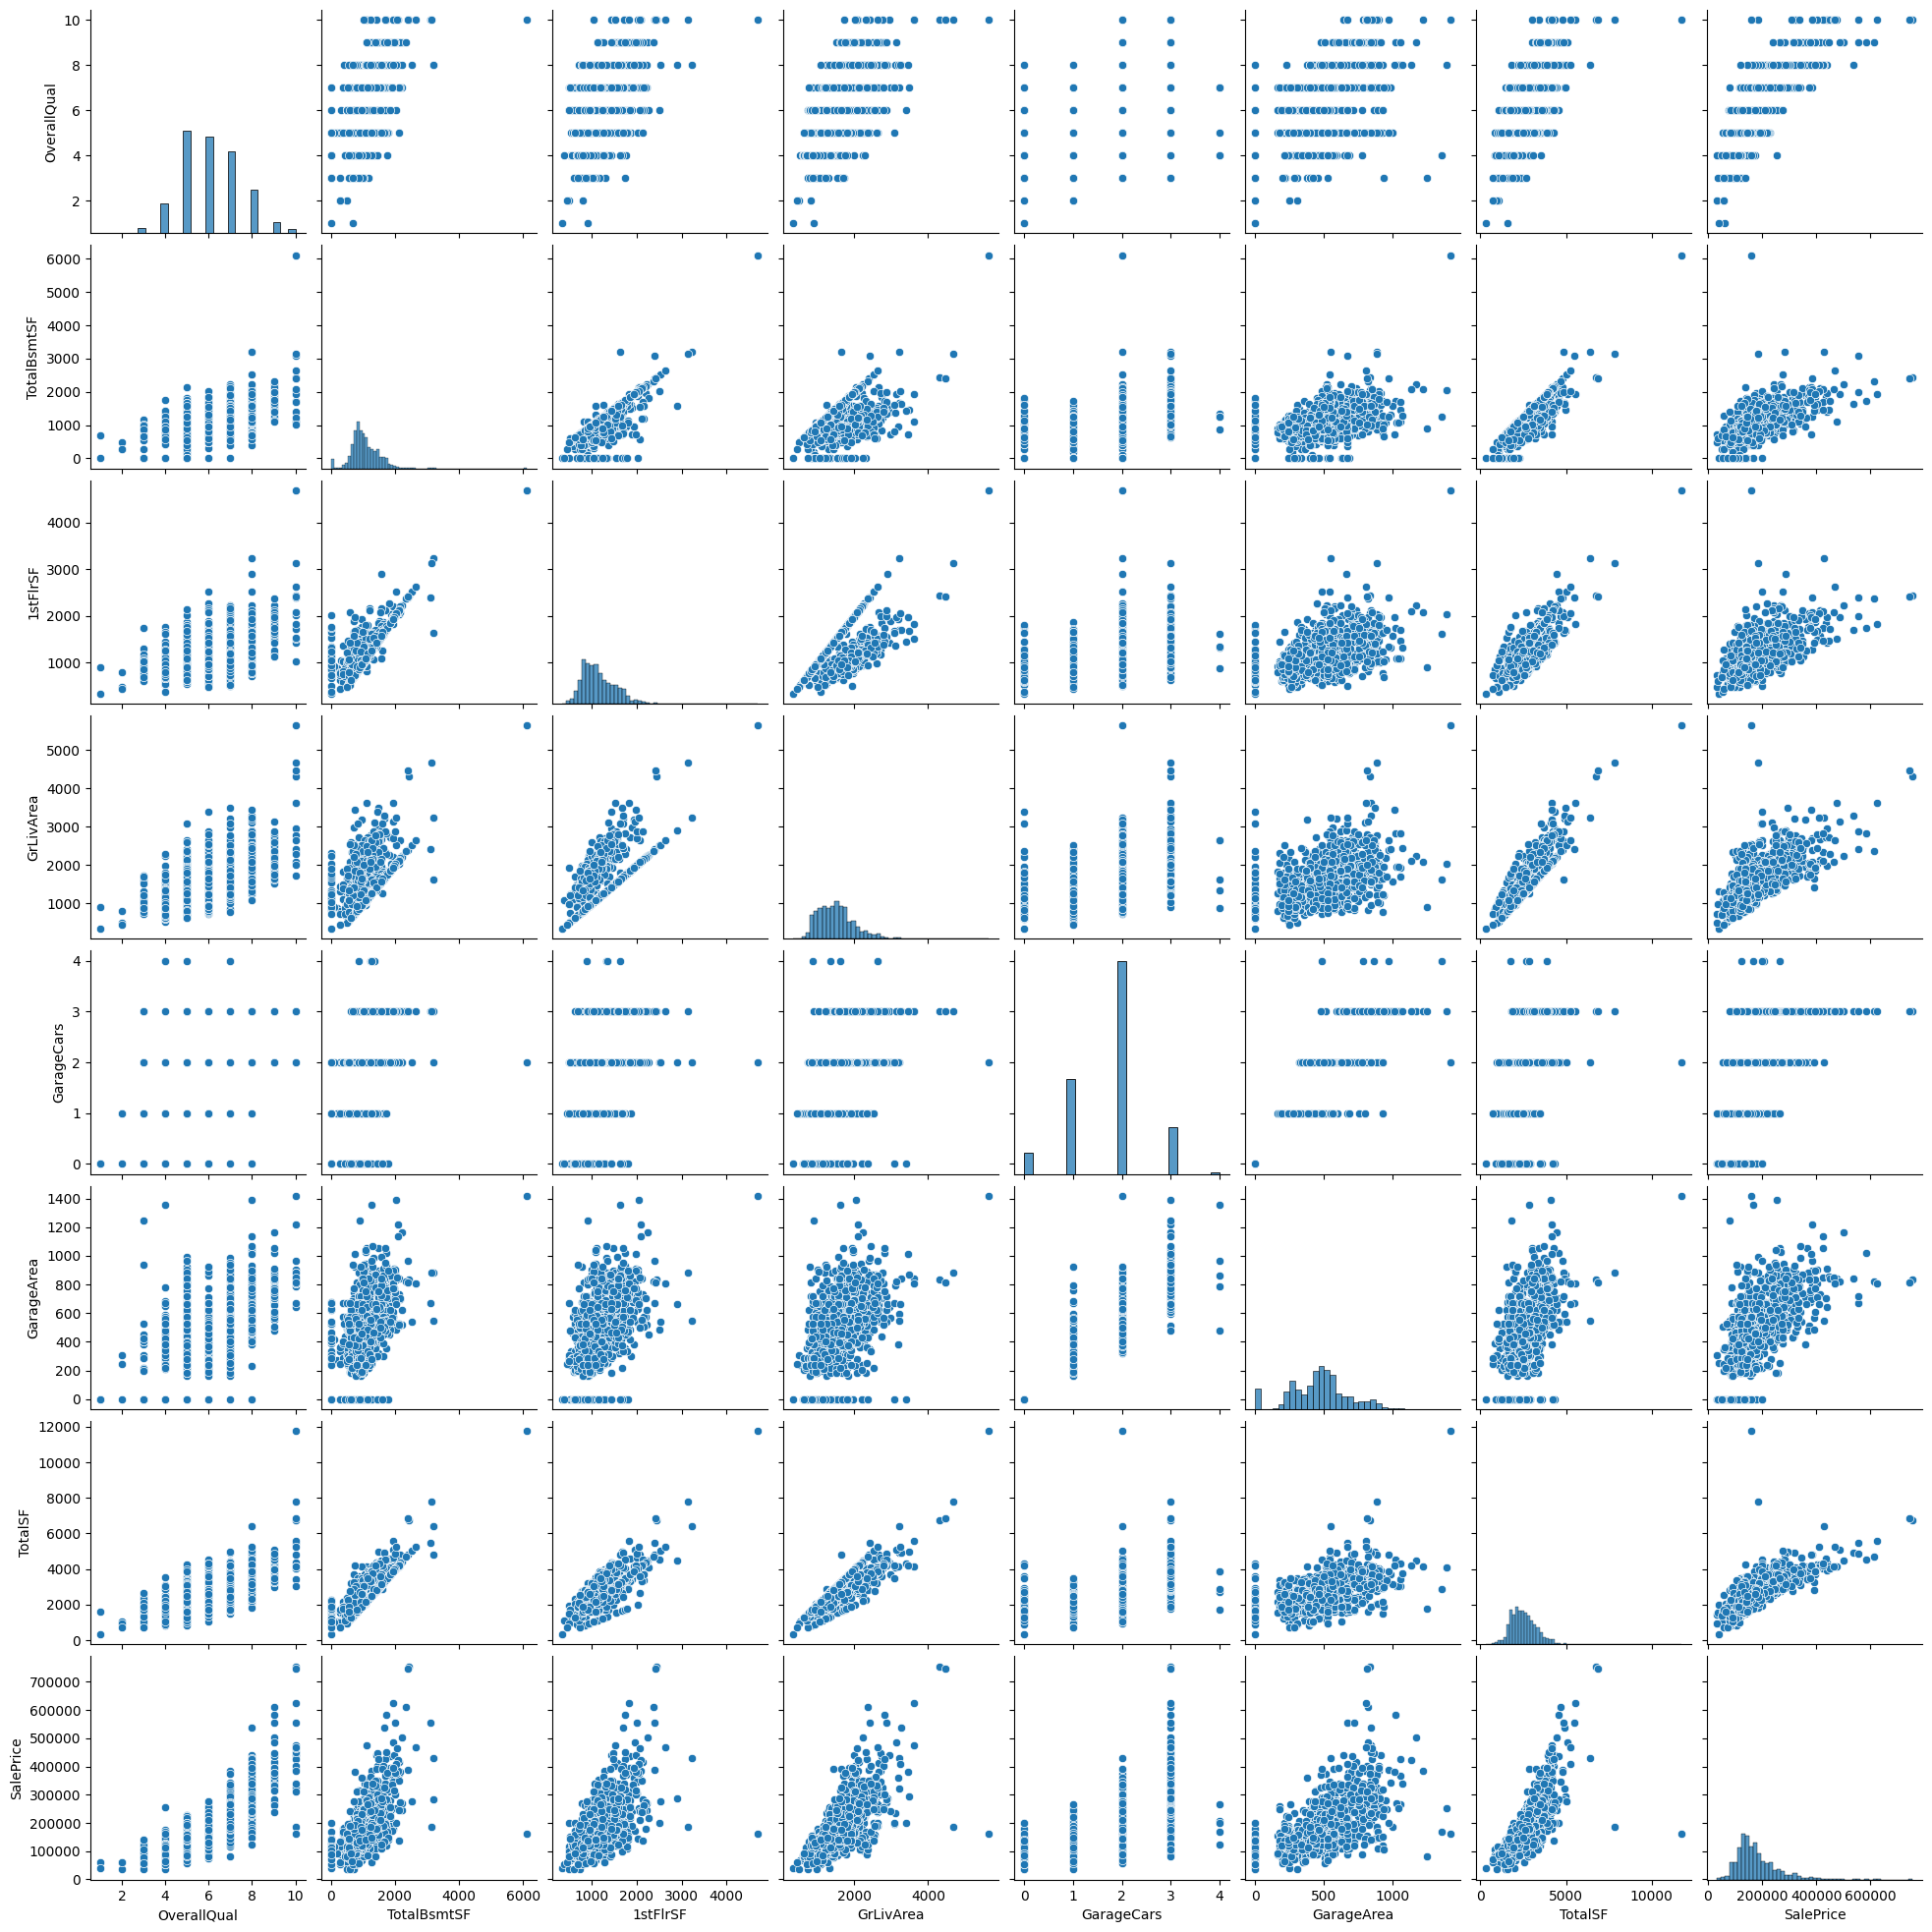

In [9]:
sns.pairplot(extracted_df)
plt.show()

In [10]:
#外れ値削除
extracted_df = extracted_df.drop(extracted_df[(extracted_df["GrLivArea"]>4000) & (extracted_df['SalePrice']>100000)].index)

In [20]:
X = extracted_df[["OverallQual",  "GrLivArea",  "TotalSF"]]
y = extracted_df["SalePrice"]

In [21]:
scl = StandardScaler()
std_X = scl.fit_transform(X)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(std_X, y, test_size=0.2, random_state=42)

In [23]:
X_train

array([[-0.79506274, -0.38760515,  0.10117479],
       [ 0.66564559,  1.51717693,  1.33849057],
       [-0.79506274, -0.2406188 , -0.46603821],
       ...,
       [-0.06470858, -0.87487499, -1.2297971 ],
       [-0.06470858, -0.8245372 , -0.5465033 ],
       [ 0.66564559,  0.9111099 ,  0.33597458]])

In [24]:
lin_model = RandomForestRegressor(n_estimators=100, random_state=42)
# lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_pred = lin_model.predict(X_test)
lin_rmse = np.sqrt(mean_squared_error(y_test, lin_pred))
print(f"Linear Regression RMSE: {lin_rmse:.2f}")

Linear Regression RMSE: 32236.86


In [ ]:
# from sklearn.metrics import mean_squared_error
# # モデルの構築
# model = keras.Sequential([
#     layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # 1つ目の隠れ層
#     layers.Dense(64, activation='relu'),                                   # 2つ目の隠れ層
#     layers.Dense(32, activation='relu'),                                   # 3つ目の隠れ層
#     layers.Dense(16, activation='relu'),                                   # 3つ目の隠れ層
#     layers.Dense(1)                                                       # 出力層（線形活性化関数）
# ])

# # モデルのコンパイル
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# # モデルの学習
# history = model.fit(X_train, y_train, validation_split=0.2, epochs=300, batch_size=64, verbose=0)

# # 予測
# y_pred = model.predict(X_test)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print(f"RMSE: {rmse:.2f}")

In [25]:
X_val = test1[["OverallQual",  "GrLivArea",  "TotalSF"]]
scl = StandardScaler()
std_X_val = scl.fit_transform(X_val)
lin_val_pred = lin_model.predict(std_X_val)

In [26]:
compare_result = test[["Id"]].copy()
compare_result["SalePrice"] = lin_val_pred
compare_result.head()

,Id,SalePrice
0,1461,130124.551587
1,1462,156730.590000
2,1463,135318.940000
3,1464,174960.000000
4,1465,216310.760000


In [27]:
compare_result.to_csv('submission.csv', index=False)